In [1]:
import numpy as np
import pandas as pd 

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))


In [2]:
#Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten, Input, Add, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np


**Load dataset**

In [3]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

In [4]:

total_classes = len(os.listdir(train_dir))
total_images = sum([len(files) for r, d, files in os.walk(train_dir)])

print(f"Total classes: {total_classes}")
print(f"Total number of images in training set: {total_images}")

Total classes: 2
Total number of images in training set: 5216


****Data augmentation****

The training generator applies data augmentation techniques such as rescaling, rotation, shifting, shearing, zooming, and flipping to enhance the diversity of the training dataset.
The validation generator only rescales the pixel values (normalizes) without augmentation to evaluate the model on unaltered data.

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Data generators for training, validation, and testing datasets using the flow_from_directory method. Each generator preprocesses images by resizing them to 150x150, batching them in groups of 32, and setting the labels for a binary classification task. 

****Model structure****

In [7]:
def residual_block(x, filters, kernel_size=3, strides=1):
    shortcut = x

    # If the number of filters is different, apply a 1x1 convolution to the shortcut
    if x.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = tf.keras.activations.relu(x)
    return x

In [8]:
input = Input(shape=(150, 150, 3))
x = Conv2D(64, (3, 3), padding='same', activation='relu')(input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = residual_block(x, 64)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = residual_block(x, 128)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = residual_block(x, 256)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 150,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 150, 150,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 75, 75,    │     36,928 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 75, 75,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 75, 75,    │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 75, 75,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 75, 75,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 37, 37,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 37, 37,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 37, 37,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 37, 37,    │      8,320 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 37, 37,    │    147,584 │ re_lu_2[0][0]   

 Total params: 1,361,153 (5.19 MB)

 Trainable params: 1,358,465 (5.18 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [10]:
# Callbacks for early stopping, learning rate reduction, and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,  # Increased epochs
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734670539.219319     111 service.cc:145] XLA service 0x7d3cc80020c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734670539.219376     111 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734670539.219380     111 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/163 ━━━━━━━━━━━━━━━━━━━━ 53:54 20s/step - accuracy: 0.4062 - loss: 0.8441

I0000 00:00:1734670549.687235     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 521ms/step - accuracy: 0.8295 - loss: 0.3713 - val_accuracy: 0.5000 - val_loss: 3.6531 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 3.6531 - learning_rate: 0.0010
Epoch 3/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 375ms/step - accuracy: 0.8778 - loss: 0.2847 - val_accuracy: 0.5000 - val_loss: 6.5212 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 6.5212 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 376ms/step - accuracy: 0.9041 - loss: 0.2290 - val_accuracy: 0.5000 - val_loss: 10.5404 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 10.5404 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 371ms/step - accuracy: 0.9244 - loss: 0.1879 - val_accuracy: 0.5000 - val_loss: 11.0199 - learning_rate: 2.0000e-04
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 11.0199 - learning_rate: 2.0000e-04
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 369ms/

****Evaluate model****

In [12]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 660ms/step - accuracy: 0.8332 - loss: 0.3836
Test Accuracy: 78.21%


Sample image prediction 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


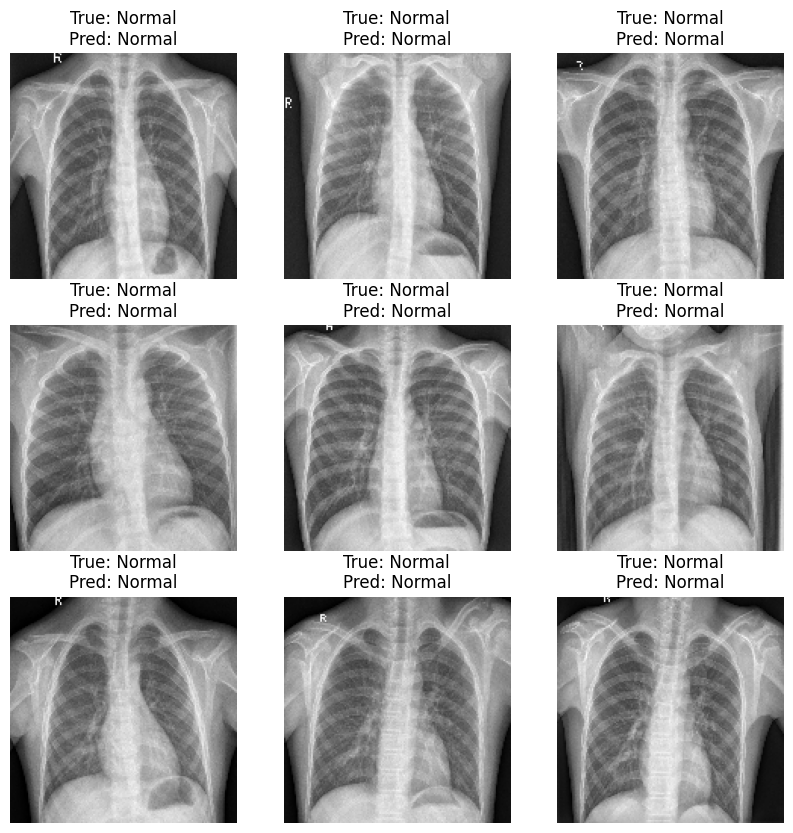

In [13]:
sample_images, sample_labels = next(test_generator)
predictions = model.predict(sample_images)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    
    # Convert the predicted probability to a label (0 or 1)
    predicted_label = 'Pneumonia' if predictions[i] > 0.5 else 'Normal'
    
    # Convert the true label (0 or 1) to a human-readable label
    true_label = 'Pneumonia' if sample_labels[i] == 1 else 'Normal'
    
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.show()